In [1]:
from dataclasses import dataclass
import h5py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from abc import ABC, abstractmethod
import torch.nn.functional as F
import math
from PIL import Image
import os
from torch.utils.tensorboard import SummaryWriter
import copy
from tqdm import tqdm
from torchvision import transforms

In [2]:
@dataclass
class TrainConfig:
    push_to_hub = "Xsmos/ml21cm"
    hub_private_repo = False
    dataset_name = "/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_batch_size = 50
    HII_DIM = 32
    num_redshift = 128
    n_sample = 4 # 64, the number of samples in sampling process
    n_param = 2

config = TrainConfig()
print(config.device)

cuda


In [3]:
# !h5dump -H /storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5

In [4]:
class Dataset4h5(Dataset):
    def __init__(self, dir_name, num_image=500, field='brightness_temp', shuffle=False, idx=None, num_redshift=config.num_redshift, HII_DIM=config.HII_DIM, normalize=True):
        super().__init__()
        
        self.dir_name = dir_name
        self.num_image = num_image
        self.field = field
        self.shuffle = shuffle
        self.idx = idx
        self.num_redshift = num_redshift
        self.HII_DIM = HII_DIM

        self.load_h5()
        if normalize:
            self.images = self.normalize(self.images)
            self.params = self.normalize(self.params)

        self.len = len(self.params)
        self.images = torch.from_numpy(self.images)
        self.params = torch.from_numpy(self.params)
        print(f"params normalized to [{self.params.min()}, {self.params.max()}]")
        print(f"images normalized to [{self.images.min()}, {self.images.max()}]")

    def load_h5(self):
        with h5py.File(self.dir_name, 'r') as f:
            print(f"dataset content: {f.keys()}")
            max_num_image = f['brightness_temp'].shape[0]
            print(f"{max_num_image} images can be loaded")

            if self.idx is None:
                if self.shuffle:
                    self.idx = np.sort(random.sample(range(max_num_image), self.num_image))
                    print(f"loading {self.num_image} images randomly")
                    # print(self.idx)
                else:
                    self.idx = range(self.num_image)
                    print(f"loading {len(self.idx)} images with idx = {self.idx}")
            else:
                print(f"loading {len(self.idx)} images with idx = {self.idx}")

            self.params = f['params']['values'][self.idx]
            print("params loaded:", self.params.shape)
            
            self.images = f[self.field][self.idx,:1,:self.HII_DIM,-self.num_redshift:][:,None]
            print(f"images loaded:", self.images.shape)
            # plt.imshow(self.images[0,0,0])
            # plt.show()

    def normalize(self, value, to=[-1,1]):
        # print(np.ndim(value))
        if np.ndim(value)==2:
            # print(f"Normalize params of shape {value.shape}")
            ranges = \
                {
                    0: [4, 6],
                    1: [10, 250]
                }
        # elif np.ndim(value)==5:  
        else:  
            # value = np.array(value)
            # print(f"Normalize images of shape {np.shape(value)}")
            ranges = \
                {
                    0: [0, 70],
                }
        for i in range(np.shape(value)[1]):
            value[:,i] = (value[:,i] - ranges[i][0]) / (ranges[i][1]-ranges[i][0])

        value = value * (to[1]-to[0]) + to[0]
        return value 

    def __getitem__(self, index):
        return self.images[index], self.params[index]

    def __len__(self):
        return self.len


dataset = Dataset4h5(config.dataset_name)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
loading 500 images with idx = range(0, 500)
params loaded: (500, 2)
images loaded: (500, 1, 1, 32, 128)
params normalized to [-0.9974921344614107, 0.998834686788082]
images normalized to [-1.0, 1.4976611137390137]


torch.Size([50, 1, 1, 32, 128])
tensor(1.3801) tensor(-1.)
torch.Size([50, 2])
tensor(0.9980, dtype=torch.float64) tensor(-0.9702, dtype=torch.float64)


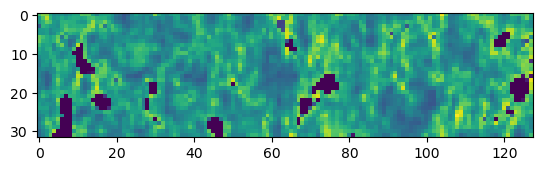

In [5]:
images, params = next(iter(dataloader))
print(images.shape)
print(images.max(), images.min())
print(params.shape)
print(params.max(), params.min())
plt.imshow(images[0,0,0])

In [6]:
# def load_h5(dir_name, num_image=100, field='brightness_temp', shuffle=True, idx=None, num_redshift=config.num_redshift, HII_DIM=config.HII_DIM):
#     with h5py.File(dir_name, 'r') as f:
#         print(f"content: {f.keys()}")
#         max_num_image = f['brightness_temp'].shape[0]
#         print(f"{max_num_image} images can be loaded")

#         if idx is None:
#             if shuffle:
#                 idx = np.sort(random.sample(range(max_num_image), num_image))
#                 print(f"loading {num_image} images randomly")
#                 # print(idx)
#             else:
#                 idx = range(num_image)
#                 print(f"loading {len(idx)} images with idx = {idx}")
#         else:
#             print(f"loading {len(idx)} images with idx = {idx}")

#         params = f['params_seeds']['values'][idx,:2]
#         print("params loaded:", params.shape)
        
#         images = f[field][idx,:HII_DIM,:HII_DIM,:num_redshift][:,None]
#         print(f"{field} loaded:", images.shape)

#     return images, params

# # def __getitem__(self, index):
# #     return images[index], params[index]

# # def __len__(self):
# #     return len


In [7]:
# # dataset = Dataset4h5(config.dataset_name, random=True, num_image=10, num_redshift=1)
# dataset = Dataset4h5(config.dataset_name)

# composed = transforms.Compose(
#     [
#         # transforms.Resize((config.image_size, config.image_size)),
#         # transforms.RandomHorizontalFlip(),
#         # transforms.ToTensor(),
#         transforms.Normalize([0], [40]),
#         # transforms.Normalize([1], [1]),
#     ]
# )

# def normalize(value, ranges = None):
#     # print(np.ndim(value))
#     if np.ndim(value)==2:
#         print(f"Normalize params of shape {value.shape}")
#         ranges = ranges or \
#             {
#                 0: [4, 6],
#                 1: [10, 250]
#             }
#     elif np.ndim(value)==5:  
#         # value = np.array(value)
#         print(f"Normalize images of shape {np.shape(value)}")
#         ranges = ranges or \
#             {
#                 0: [0, 70],
#             }
#     for i in range(np.shape(value)[1]):
#         value[:,i] = (value[:,i] - ranges[i][0]) / (ranges[i][1]-ranges[i][0])
#         # value = Image.fromarray(np.uint8(value*255))
#     return value 

# # def transform(examples):
# #     images = [preprocess(image.convert("RGB")) for image in examples["image"]]
# #     return {"images": images}

# # dataset.set_transform(transform)
# dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [8]:
# def load_numpy_dataset(np_array, split='train'):
#     assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
#     # print("load_numpy_dataset, np_array.shape =", np_array.shape)
#     dataset = Dataset.from_dict({'values': np_array})
#     return dataset
    
# # def normalize(image):
# #     initial_data = np.array(image)
# #     data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
# #     # data = (normalized_data*255).astype(np.uint8)
# #     data = Image.fromarray(np.uint8(data*255))
# #     return data

# images, params = load_h5(config.dataset_name)
# images = normalize(images)
# dataset = load_numpy_dataset(images)
# params_normalized = normalize(params)

# # print(type(dataset))
# # print(len(dataset))
# # print(np.shape(dataset))
# # print(dataset)
# # print(np.shape(dataset['values']))


# # preprocess = transforms.Compose(
# #     [
# #         # normalize(),
# #         # transforms.Resize((config.image_size[0], config.image_size[1])),
# #         # transforms.RandomVerticalFlip(),
# #         transforms.ToTensor(),
# #         # transforms.Normalize([0.5],[0.5]),
# #     ]
# # )

# # def transform(examples):
# #     images = [preprocess(normalize(image)) for image in examples['values']]
# #     # images = [preprocess(image) for image in examples['image']]
# #     # print(np.shape(images[0]))
# #     return {"images": images}

# # datasets = transform(Tb)
# # dataset.set_transform(transform)
# # dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

# Add noise:

\begin{align*}
x_t &\sim \mathcal N\left(\sqrt{1-\beta_t}\ x_{t-1},\ \beta_t \right) \\
x_t &\equiv \sqrt{1-\beta_t}\ x_{t-1} + \sqrt{\beta_t}\ \epsilon\\
\epsilon &\sim \mathcal N(0,1)\\
\alpha_t & \equiv 1 - \beta_t\\
& ...\\
x_t &= \sqrt{\bar {\alpha_t}} x_0 + \epsilon\ \sqrt{1 - \bar{\alpha_t}}\\
\bar {\alpha_t} &\equiv \prod_{i=1}^t \alpha_i\\
&= \exp\left({\ln{\prod_{i=1}^t \alpha_i}}\right)\\
&= \exp\left({\sum_{i=1}^t\ln{ \alpha_i}}\right)
\end{align*}

In [9]:
class DDPMScheduler(nn.Module):
    def __init__(self, betas: tuple, num_train_timesteps: int, device='cpu', drop_prob=0.1, cond=False):
        super().__init__()
        
        beta_1, beta_T = betas
        assert 0 < beta_1 <= beta_T <= 1, "ensure 0 < beta_1 <= beta_T <= 1"
        self.device = device
        self.num_train_timesteps = num_train_timesteps
        self.beta_t = torch.linspace(beta_1, beta_T, self.num_train_timesteps) * (beta_T-beta_1) + beta_1
        self.beta_t = self.beta_t.to(self.device)

        self.drop_prob = drop_prob
        self.cond = cond
        self.alpha_t = 1 - self.beta_t
        self.bar_alpha_t = torch.exp(torch.cumsum(torch.log(self.alpha_t), dim=0))

    def add_noise(self, clean_images):
        noise = torch.randn_like(clean_images).to(self.device)
        ts = torch.randint(0, self.num_train_timesteps, (clean_images.shape[0],)).to(self.device)
        
        noisy_images = (
            clean_images * torch.sqrt(self.bar_alpha_t[ts])[:, None, None, None, None]
            + noise * torch.sqrt(1-self.bar_alpha_t[ts])[:, None, None, None, None]
            )
        # print(x_t.shape)
        return noisy_images, noise, ts

    def sample(self, nn_model, n_sample, shape, device, test_param, guide_w = 0.0):
        x_i = torch.randn(n_sample, *shape).to(device)
        # print("x_i.shape =", x_i.shape)
        if self.cond == True:
            c_i = test_param
            uncond_tokens = torch.tensor(np.float32(np.array([0,0]))).to(device)
            uncond_tokens = uncond_tokens.repeat(int(n_sample),1)
            c_i = torch.cat((c_i, uncond_tokens), 0)

        x_i_store = [] # keep track of generated steps in case want to plot something
        # print("self.num_train_timesteps =", self.num_train_timesteps)
        # for i in range(self.num_train_timesteps, 0, -1):
        # print(f'sampling!!!')
        for i in reversed(range(0, self.num_train_timesteps)):
            print(f'sampling timestep {i:4d}',end='\r')
            t_is = torch.tensor([i]).to(device)
            t_is = t_is.repeat(n_sample)

            z = torch.randn(n_sample, *shape).to(device) if i > 0 else 0

            # double batch
            if self.cond == True:
                x_i = x_i.repeat(2,1,1,1,1)
                t_is = t_is.repeat(2)

                # split predictions and compute weighting
                eps = nn_model(x_i, t_is,c_i)
                eps1 = eps[:n_sample]
                eps2 = eps[n_sample:]
                eps = (1+guide_w)*eps1 - guide_w*eps2
                x_i = x_i[:n_sample]
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            else:
                eps = nn_model(x_i, t_is)
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            # print("x_i.shape =", x_i.shape)
            x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            # print("x_i.shape =", x_i.shape)
            # store only part of the intermediate steps
            #if i%20==0 or i==self.num_train_timesteps or i<8:
            #    x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


# ddpm_scheduler = DDPMScheduler((1e-4,0.2),10)
# noisy_images, noise, ts = ddpm_scheduler.add_noise(images)

In [10]:
# idx = 1
# print(noisy_images.shape)
# print(params[idx])
# plt.imshow(images[idx,0,0,...])
# plt.show()
# print(ts[idx])
# plt.imshow(noisy_images[idx,0,0,...])
# plt.show()
# plt.show()

In [11]:
class Downsample(nn.Module):
    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        stride = (1,2,4)
        if use_conv:
            # print("conv")
            self.op = nn.Conv3d(channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            # print("pool")
            assert channels == self.out_channels
            self.op = nn.AvgPool3d(kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)

In [12]:
class Upsample(nn.Module):
    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels
        self.use_conv = use_conv
        if self.use_conv:
            self.conv = nn.Conv3d(self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        stride = (1,2,4)
        # print(torch.tensor(x.shape[2:]))
        # print(torch.tensor(stride))
        shape = torch.tensor(x.shape[2:]) * torch.tensor(stride)
        shape = tuple(shape.detach().numpy())
        # print(shape)
        x = F.interpolate(x, shape, mode='nearest')
        if self.use_conv:
            x = self.conv(x)
        return x

In [13]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

In [14]:
class TimestepBlock(ABC, nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        test
        """

In [15]:
class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb, encoder_out=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, AttentionBlock):
                x = layer(x, encoder_out)
            else:
                x = layer(x)
        return x

In [16]:
class ResBlock(TimestepBlock):
    def __init__(
        self, channels, emb_channels, dropout, out_channels=None, use_conv=False, use_checkpoint=False, use_scale_shift_norm=False, up=False, down=False,
        ):
        super().__init__()
        self.out_channels = out_channels or channels
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            nn.BatchNorm3d(channels), # normalize to standard gaussian
            nn.Identity(),
            nn.Conv3d(channels, self.out_channels, 3, padding=1),
            )

        self.updown = up or down
        if up:
            self.h_updown = Upsample(channels, False)
            self.x_updown = Upsample(channels, False)
        elif down:
            self.h_updown = Downsample(channels, False)
            self.x_updown = Downsample(channels, False)
        else:
            self.h_updown = self.x_updown = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels
                ),
        )

        self.out_layers = nn.Sequential(
            nn.BatchNorm3d(self.out_channels),
            nn.SiLU() if use_scale_shift_norm else nn.Identity(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv3d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv3d(channels, self.out_channels, 3, padding=1)
        else:
            self.skip_connection = nn.Conv3d(channels, self.out_channels, 1)
        

    def forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_updown(h)
            x = self.x_updown(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)

        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1+scale) + shift
            h = out_rest(h)
        else:
            h += emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

In [17]:
class QKVAttention(nn.Module):
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads
        # print("QKVAttention, self.n_heads =", self.n_heads)
        
    def forward(self, qkv, encoder_kv=None):
        bs, width, length = qkv.shape
        assert width % (3*self.n_heads) == 0
        ch = width // (3*self.n_heads)

        # print("QKVAttention", bs, self.n_heads, ch, length)
        q, k, v = qkv.reshape(bs*self.n_heads, ch*3, length).split(ch, dim=1)
        if encoder_kv is not None:
            assert encoder_kv.shape[1] == self.n_heads * ch * 2
            ek, ev = encoder_kv.reshape(bs*self.n_heads, ch*2, -1).split(ch, dim=1)
            k = torch.cat([ek,k], dim=-1)
            v = torch.cat([ev,v], dim=-1)

        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum("bct,bcs->bts", q*scale, k*scale)
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)

        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

In [18]:
class AttentionBlock(nn.Module):
    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        encoder_channels=None,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0,\
                f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels

        self.use_checkpoint = use_checkpoint
        self.norm = nn.BatchNorm3d(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        
        self.attention = QKVAttention(self.num_heads)

        if encoder_channels is not None:
            self.encoder_kv = nn.Conv1d(encoder_channels, channels * 2, 1)
        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x, encoder_out=None):
        b, c, *spatial = x.shape
        qkv = self.qkv(self.norm(x).view(b, c, -1))
        if encoder_out is not None:
            encoder_out = self.encoder_kv(encoder_out)
            h = self.attention(qkv, encoder_out)
        else:
            h = self.attention(qkv)
        h = self.proj_out(h)
        return x + h.reshape(b, c, *spatial)

In [19]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    #print (timesteps.shape)
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    #print (timesteps[:, None].float().shape,freqs[None].shape)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [36]:
class ContextUnet(nn.Module):
    def __init__(
        self,
        # image_size,
        n_param=2,
        in_channels=1,
        model_channels=96,
        out_channels = 1,
        channel_mult = (1,2,3),
        num_res_blocks = 3,
        dropout = 0,
        use_checkpoint = False,
        use_scale_shift_norm = False,
        attention_resolutions = (4, 8),
        num_heads = 16,
        num_head_channels = -1,
        num_heads_upsample = -1,
        resblock_updown = False,
        conv_resample = True,
        encoder_channels = None,
        ):
        super().__init__()

        # print("before, ContextUnet, num_heads_upsample =", num_heads_upsample, "num_heads =", num_heads)
        if num_heads_upsample == -1:
            num_heads_upsample = num_heads
        # print("after, ContextUnet, num_heads_upsample =", num_heads_upsample, "num_heads =", num_heads)

        # self.n_param = n_param
        self.model_channels = model_channels
        self.dtype = torch.float32

        self.token_embedding = nn.Linear(n_param, model_channels * 4)

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        ch = input_ch = int(channel_mult[0] * model_channels)

        ###################### input_blocks ######################
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(nn.Conv3d(in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels = int(mult * model_channels),
                        use_checkpoint = use_checkpoint,
                        use_scale_shift_norm = use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads = num_heads,
                            num_head_channels = num_head_channels,
                            encoder_channels = encoder_channels,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)

            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            # dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch


        ###################### middle_blocks ######################
        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                encoder_channels=encoder_channels,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch


        ###################### output_blocks ######################
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        # dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    # print("ds in attention_resolutions, num_heads=", num_heads_upsample)
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            encoder_channels=encoder_channels,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            # dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            nn.BatchNorm3d(ch),
            nn.Identity(),
            zero_module(nn.Conv3d(input_ch, out_channels, 3, padding=1)),
        )
        # self.use_fp16 = use_fp16

    def forward(self, x, timesteps, y=None):
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        if y != None:
            # print("y.dtype =", y.dtype)
            text_outputs = self.token_embedding(y.float())
            emb = emb + text_outputs.to(emb)

        h = x.type(self.dtype)
        # print("0,h.shape =", h.shape)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
            # print("1,h.shape =", h.shape)
        # print("2,h.shape =", h.shape)
        h = self.middle_block(h, emb)
        # print("2,h.shape =", h.shape)
        for module in self.output_blocks:
            # print("for module in self.output_blocks, h.shape =", h.shape)
            # print("len(hs) =", len(hs), ", hs[-1].shape =", hs[-1].shape)
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        h = self.out(h)
        return h 

In [37]:
test = torch.randn(2,3,4)
print(test)
print(test.dtype)
print(test.type(torch.float64))

tensor([[[-0.0740,  1.4753,  0.6177, -1.2054],
         [ 0.3624,  0.7936, -3.0819,  0.5972],
         [-0.1081,  0.8141,  1.5956,  0.6513]],

        [[ 0.2870,  1.3104,  1.5717,  1.9278],
         [ 0.1267, -1.4899, -0.1886, -1.5798],
         [-0.6871, -1.4751,  2.3128,  0.4449]]])
torch.float32
tensor([[[-0.0740,  1.4753,  0.6177, -1.2054],
         [ 0.3624,  0.7936, -3.0819,  0.5972],
         [-0.1081,  0.8141,  1.5956,  0.6513]],

        [[ 0.2870,  1.3104,  1.5717,  1.9278],
         [ 0.1267, -1.4899, -0.1886, -1.5798],
         [-0.6871, -1.4751,  2.3128,  0.4449]]], dtype=torch.float64)


In [38]:
# nn_model = ContextUnet()

In [39]:
# print("noisy_images.shape", noisy_images.shape)
# noise_pred = nn_model(noisy_images, ts, label.float())

In [40]:
# print(noise_pred.shape)
# print(noise_pred[1,0,...,0])

In [41]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model):
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [42]:
def train_eor():

    ###########################
    ## hardcoding these here ##
    ###########################
    
    # general parameters for the name and logger
    run_name = 'test01' # the unique name of each experiment
    logger = SummaryWriter(os.path.join("runs", run_name)) # To log
    
    # parameter for DDPM
    num_train_timesteps = 100 # 1000, 500; DDPM time steps
    ws_test = [0]#[0,0.1] #[0,0.5,2] strength of generative guidance

    # parameters for training unet
    device = "cuda" if torch.cuda.is_available() else "cpu" # using gpu or optionally "cpu"
    n_epoch = 2 # 120
    lrate = 1e-4
    save_model = False
    save_dir = './outputs/'
    save_freq = 1 #10 # the period of saving model
    ema=True # whether to use ema
    ema_rate=0.995
    cond = False # if training using the conditional information
    lr_decay = False # if using the learning rate decay
    resume = False # if resume from the trained checkpoints
    
    # parameters for sampling
    sample_freq = 1 # the period of sampling
    test_param_single=torch.tensor([0.2,0.80000023]) # parameter for us for condional testing
    # n_sample = 10 # 64, the number of samples in sampling process
    test_param = torch.tile(test_param_single,(config.n_sample,1)) # repeat to perform multiple sampling
    test_param =  test_param.to(device)
    
    # parameters for dataset
    # batch_size = 2 # 16
    # config.HII_DIM= config.HII_DIM # 64
    drop_prob = 0.28 # the probability to drop the parameters for unconditional training in classifier free guidance.
    # n_param = 2 # dimension of parameters
    data_dir = './data' # data directory
    
    ########################
    ## ready for training ##
    ########################
    # initialize the DDPM
    ddpm = DDPMScheduler(betas=(1e-4, 0.02), num_train_timesteps=num_train_timesteps, device=device, drop_prob=drop_prob,cond=cond)

    # initialize the unet
    nn_model = ContextUnet(n_param=config.n_param)
    nn_model.train()
    nn_model.to(device)

    # parameters to be optimized
    params_to_optimize = [
        {'params': nn_model.parameters()}
    ]

    # number of parameters to be trained
    number_of_params = sum(x.numel() for x in nn_model.parameters())
    print(f"Number of parameters for unet: {number_of_params}")

    # optionally load a model
    if resume:
        ddpm.load_state_dict(torch.load(os.path.join(save_dir, f"train-{ep}xscale_test_{run_name}.npy")))

    # define the loss function
    loss_mse = nn.MSELoss()

    # initialize the dataset
    dataset = Dataset4h5(config.dataset_name)
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
    # dataset = TextImageDataset(
    #         folder=data_dir,
    #         config.HII_DIM=config.HII_DIM,
    #         uncond_p=drop_prob, # only used when drop_para=True
    #         shuffle=True,
    #         n_param=n_param,
    #         drop_para=True if cond==True else False
    #     )

    # # data loader setup
    # dataloader = torch.utils.data.DataLoader(
    #     dataset,
    #     batch_size=batch_size,
    #     shuffle=True,
    #     num_workers=0,
    #     pin_memory=(device == device),
    # )
    
    length = len(dataloader)
    # print("length =", length)
    # print("config.train_batch_size =", config.train_batch_size)

    # initialize optimizer
    optim = torch.optim.Adam(params_to_optimize, lr=lrate)

    # whether to use ema
    if ema:
        ema = EMA(0.995)
        if resume:
            ema_model = DDPMScheduler(nn_model=nn_model, betas=(1e-4, 0.02), num_train_timesteps=num_train_timesteps, device=device, drop_prob=drop_prob,cond=cond)
            ema_model.load_state_dict(torch.load(os.path.join(save_dir, f"train-{ep}xscale_test_{run_name}_ema.npy")))
        else:
            ema_model = copy.deepcopy(nn_model).eval().requires_grad_(False)

    ###################      
    ## training loop ##
    ###################
    # plot_unet = True
    for ep in range(n_epoch):
        # print(f'epoch {ep}')
        # print("ddpm.train()")
        ddpm.train()
        # linear lrate decay
        if lr_decay:
            optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        # data loader with progress bar
        pbar = tqdm(dataloader)
        for i, (x, c) in enumerate(pbar):
            # print("x.max =", x.max(), "x.min =", x.min(), 'c =', c)
            # x = composed(x)
            # print("x.max =", x.max(), "x.min =", x.min(), 'c =', c)
            optim.zero_grad()
            x = x.to(device)
            xt, noise, ts = ddpm.add_noise(x)
            # if plot_unet:
            #     plot_unet = False
            #     logger.add_graph(nn_model, xt, ts)
            # noisy_images, noise, ts
            if cond == True:
                c = normalize(c)
                c = c.to(device)
                noise_pred = nn_model(xt, ts, c)
            else:
                noise_pred = nn_model(xt, ts)
            loss = loss_mse(noise, noise_pred)
            loss.backward()

            pbar.set_description(f"epoch {ep} loss {loss.item():.4f}")
            optim.step()

            # ema update
            if ema:
                ema.step_ema(ema_model, nn_model)

            # logging loss
            logger.add_scalar("MSE", loss.item(), global_step=ep * length + i)

            
        # save model
        if save_model:
            model_state = {
                'epoch': ep,
                'unet_state_dict': nn_model.state_dict(),
                'ema_unet_state_dict': ema_model.state_dict()
                }
            torch.save(model_state, save_dir + f"model_epoch_{ep}_test_{run_name}.tar")
            # print('saved model at ' + save_dir + f"model__epoch_{ep}_test_{run_name}.pth")
            
        # sample the image
        if ep == n_epoch-1:# and ep%sample_freq==0:
            nn_model.eval()
            with torch.no_grad():

                # loop over the guidance scale
                for w in ws_test: 
                    
                    x_gen_tot_ema = []
                    x_gen_tot = []

                    # only output the image x0, omit the stored intermediate steps, OTHERWISE, uncomment 
                    # line 142, 143 and output 'x_gen, x_store = ' here.
                    x_gen, _ = ddpm.sample(nn_model,config.n_sample, (1,config.HII_DIM,config.HII_DIM, config.num_redshift), device, test_param=test_param, guide_w=w)
                    x_gen_ema, _ = ddpm.sample(ema_model,config.n_sample, (1,config.HII_DIM,config.HII_DIM, config.num_redshift), device, test_param=test_param, guide_w=w)

                    # x_gen_tot.append(np.array(x_gen.cpu()))
                    # x_gen_tot=np.array(x_gen_tot)
                    # x_gen_tot_ema.append(np.array(x_gen_ema.cpu()))
                    # x_gen_tot_ema=np.array(x_gen_tot_ema)

                    sample_save_path_final = os.path.join(save_dir, f"train-{ep}-scale_{w}_{run_name}.npy")
                    # np.save(str(sample_save_path_final),x_gen_tot)
                    np.save(str(sample_save_path_final),x_gen.detach().cpu())

                    sample_save_path_final = os.path.join(save_dir, f"train-{ep}-scale_{w}_{run_name}_ema.npy")
                    # np.save(str(sample_save_path_final),x_gen_tot_ema)
                    np.save(str(sample_save_path_final),x_gen_ema.detach().cpu())

In [43]:
if __name__ == "__main__":
    train_eor()

Number of parameters for unet: 80157505
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
loading 500 images with idx = range(0, 500)
params loaded: (500, 2)
images loaded: (500, 1, 1, 32, 128)
params normalized to [-0.9974921344614107, 0.998834686788082]
images normalized to [-1.0, 1.4976611137390137]


epoch 1 loss 0.6708: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


In [44]:
ls -lth outputs

total 4.1M
-rw-r--r-- 1 bxia34 p-jw254 2.1M May  7 01:08 train-1-scale_0_test01_ema.npy
-rw-r--r-- 1 bxia34 p-jw254 2.1M May  7 01:08 train-1-scale_0_test01.npy


In [ ]:
# samples = np.load("outputs/train-4-scale_0.1_test01_ema.npy")
# print(samples.shape)
# print(samples.min(), samples.max())
# # plt.imshow(samples[0,0,:,:,0])
# # plt.show()
# for i in range(config.n_sample):
#     plt.imshow(samples[i,0,0,:,:])
#     plt.show()

(4, 1, 32, 32, 128)


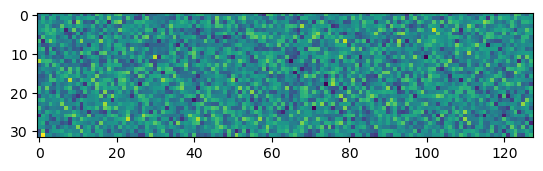

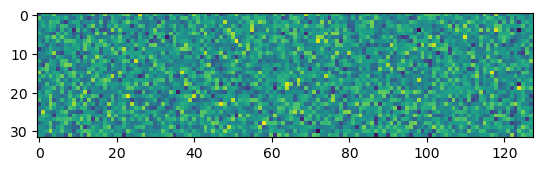

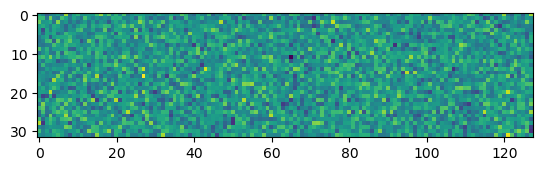

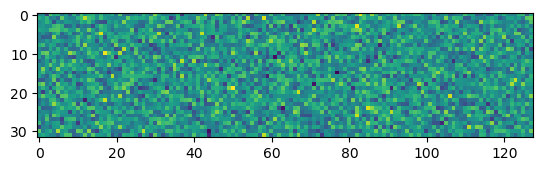

In [45]:
samples = np.load("outputs/train-1-scale_0_test01_ema.npy")
print(samples.shape)
# print(samples)
# plt.imshow(samples[0,0,:,:,0])
# plt.show()
for i in range(config.n_sample):
    plt.imshow(samples[i,0,0,:,:])
    plt.show()

In [46]:
# samples = np.load("outputs/train-4-scale_0.1_test01.npy")
# print(samples.shape)
# # plt.imshow(samples[0,0,:,:,0])
# # plt.show()
# for i in range(config.n_sample):
#     plt.imshow(samples[i,0,0,:,:])
#     plt.show()

(4, 1, 32, 32, 128)


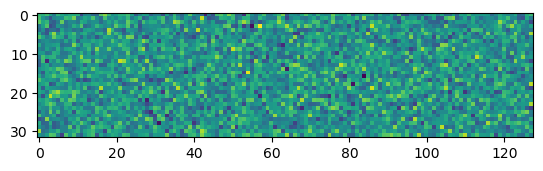

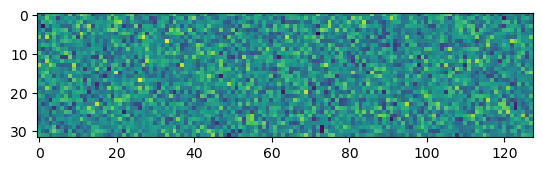

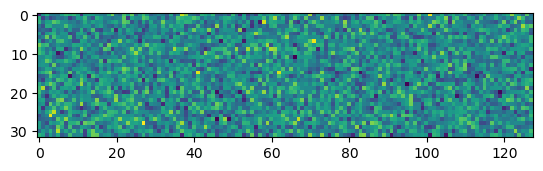

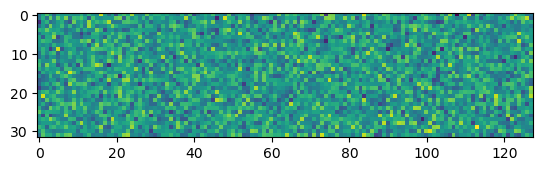

In [47]:
samples = np.load("outputs/train-1-scale_0_test01.npy")
print(samples.shape)
# plt.imshow(samples[0,0,:,:,0])
# plt.show()
for i in range(config.n_sample):
    plt.imshow(samples[i,0,0,:,:])
    plt.show()

In [ ]:
# !tensorboard --logdir=/storage/home/hcoda1/3/bxia34/p-jw254-0/ml21cm/runs/test01/events.out.tfevents.1714937832.atl1-1-03-003-17-0.pace.gatech.edu.53844.0

In [6]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
print(torch.cuda.is_available())
print(torch.__path__)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

True
['/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/torch']


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

True
Quadro RTX 6000
1


In [8]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print("x.shape =", x.shape)
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [9]:
# ResConv = ResidualConvBlock(1,1, is_res=True)
# x = torch.eye(32)
# # x = torch.stack((x,x/2,x/3), axis=0)
# # x = x.reshape(3,16,16)
# print(x.shape)
# x[int(x.shape[0]/2),:] = 1
# x[:, int(x.shape[1]/2)-1] = 1
# np.fill_diagonal(x.numpy()[:,::-1], 1)
# # plt.imshow(x.permute(1,2,0))
# plt.imshow(x)
# plt.show()
# # x = np.expand_dims(x, axis=0)
# x = x[None, :]
# print(x.shape)
# # ResConv_out = ResConv.forward(torch.stack((x,x/2), axis=0))
# ResConv_out = ResConv.forward(x[None,:])
# ResConv_out.shape
# plt.imshow(ResConv_out[0][0].detach())
# # plt.imshow(ResConv_out[0].permute(1,2,0).detach())
# plt.show()
# # plt.imshow(ResConv_out[1].permute(1,2,0).detach())
# # plt.imshow(ResConv_out[1][0].detach())
# # plt.show()

In [10]:
# ResConv = ResidualConvBlock(1,1, is_res=False)
# x = torch.eye(32)
# # x = torch.stack((x,x/2,x/3), axis=0)
# # x = x.reshape(3,16,16)
# print(x.shape)
# x[int(x.shape[0]/2),:] = 1
# x[:, int(x.shape[1]/2)-1] = 1
# np.fill_diagonal(x.numpy()[:,::-1], 1)
# # plt.imshow(x.permute(1,2,0))
# plt.imshow(x)
# plt.show()
# # x = np.expand_dims(x, axis=0)
# x = x[None, :]
# print(x.shape)
# # ResConv_out = ResConv.forward(torch.stack((x,x/2), axis=0))
# ResConv_out = ResConv.forward(x[None,:])
# ResConv_out.shape
# plt.imshow(ResConv_out[0][0].detach())
# # plt.imshow(ResConv_out[0].permute(1,2,0).detach())
# plt.show()
# # plt.imshow(ResConv_out[1].permute(1,2,0).detach())
# # plt.imshow(ResConv_out[1][0].detach())
# # plt.show()

In [11]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [30]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        # print("x.shape =", x.shape)
        # print("skip.shape =", skip.shape)
        x = torch.cat((x, skip), 1)
        # print(x)
        x = self.model(x)
        # print(x)
        return x

In [31]:
# plt.imshow(x[0])
# plt.show()
# down = UnetDown(1,1).forward(torch.stack((x,x/2), axis=0))
# print(down.shape)
# plt.imshow(down.detach()[0][0])
# plt.show()
# # plt.imshow(x[0])
# # plt.show()
# # plt.imshow(UnetUp(1,1).forward(torch.stack((x,x/2), axis=0), skip=down.detach()))
# # plt.show()

In [32]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [33]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super().__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2*n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2*n_feat, 2*n_feat, 7, 7),
            nn.GroupNorm(8, 2*n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4*n_feat, n_feat)
        self.up2 = UnetUp(2*n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2*n_feat, n_feat, 3,1,1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3,1,1),
        )
    
    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = (-1*(1-context_mask))
        c = c*context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat*2, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat*2, 1,1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1,1)
        
        up1 = self.up0(hiddenvec)
        # print("cemb.shape =", cemb1.shape, up1.shape, temb1.shape, down2.shape)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        return out

In [34]:
def ddpm_scheduler(beta1, beta2, T):
    assert 0 < beta1 < beta2 < 1.0, "make sure 0 < beta1 < beta2 < 1"
    beta_t = torch.linspace(0,1,T, dtype=torch.float32)*(beta2-beta1) + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1/torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return_list = ["alpha_t", "oneover_sqrta", "sqrt_beta_t", "alphabar_t", "sqrtab", "sqrtmab", "mab_over_sqrtmab"]
    
    return_dict = {}
    for key in return_list:
        return_dict[key] = locals()[key]
 
    return return_dict

In [35]:
# test_tensor = torch.randn(2,3)
# print(test_tensor)
# print(test_tensor.shape)
# print(type(test_tensor.shape))
# print(torch.Tensor(test_tensor.shape))
# print(torch.Tensor((2.222,3)))

In [36]:
class test_buffer(nn.Module):
    def __init__(self):
        super().__init__()
        print(self.__dict__)
        my_dict = dict(a=1, b=999, c=3)
        for k, v in my_dict.items():
            self.register_buffer(k,torch.Tensor([v]))
        # print(self.__dict__)

test = test_buffer()
print(test.a.shape, test.b.shape, test.c.shape)
print(test.a, test.b, test.c)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict()}
torch.Size([1]) torch.Size([1]) torch.Size([1])
tensor([1.]) tensor([999.]) tensor([3.])


In [37]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        "计算如何依次增加噪音"
        super().__init__()
        self.nn_model = nn_model.to(device)
            
        for k, v in ddpm_scheduler(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)
        # print("_ts: shape = ", _ts.shape, "max =", _ts.max())
        x_t = (
            self.sqrtab[_ts, None, None, None] * x +
            self.sqrtmab[_ts, None, None, None] * noise
        )

        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        noise_pred = self.nn_model(x_t, c, _ts/self.n_T, context_mask)
        
        return self.loss_mse(noise, noise_pred)

    def sample(self, n_sample, size, device, guide_w = 0):
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0,10).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        context_mask = torch.zeros_like(c_i).to(device)

        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1

        x_i_store = []
        print()
        for i in range(self.n_T-1, 0, -1):
            # print(f"sampling timestep {i}", end='\r')
            t_is = torch.Tensor([i/self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1,1,1)

            t_is = t_is.repeat(2,1,1,1)
            x_i = x_i.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 0 else 0

            # print(x_i.shape, c_i.shape, t_is.shape, context_mask.shape)
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            # print("eps.shape =", eps.shape)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2

            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps*self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z 
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [38]:
n_epoch = 20
batch_size = 256
n_T = 400
device = "cuda:0" if torch.cuda.is_available() else "cpu" #"cpu" #
n_classes = 10
n_feat = 128
lrate = 1e-4
save_model = False
save_dir = "./data/diffusion_outputs10/"
ws_test = [0, 0.5, 2]

nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
ddpm = DDPM(nn_model=nn_model, betas=(1e-4,0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

# tf = transforms.Compose([transforms.ToTensor()])
# dataset = MNIST("./data", train=True, download=True, transform=tf)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

In [39]:
print(optim.param_groups[0].keys())
print(optim.param_groups[0]['lr'])

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable'])
0.0001


In [40]:
pbar = tqdm(dataloader)
for x, c in pbar:
    print(x.shape, c.shape)
    break
print(x.shape, c.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([50, 1, 28, 28]) torch.Size([50, 2])
torch.Size([50, 1, 28, 28]) torch.Size([50, 2])


In [41]:
torch.zeros(3, dtype=int)

tensor([0, 0, 0])

In [42]:
print(x.shape)

torch.Size([50, 1, 28, 28])


In [43]:
loss = ddpm(x.to(device),torch.zeros(x.shape[0],dtype=int).to(device))
print(loss)
print(loss.item())

tensor(1.1880, device='cuda:0', grad_fn=<MseLossBackward0>)
1.1879873275756836


In [44]:
test1 = torch.randn(2,3)
print(test1.shape)
test2 = torch.Tensor(test1.shape)
print(test2)
print(test2.shape)

torch.Size([2, 3])
tensor([[1.0854e+16, 3.0611e-41, 8.4162e+15],
        [3.0611e-41, 1.1210e-43, 0.0000e+00]])
torch.Size([2, 3])


epoch 0


loss: 0.8854: 100%|██████████| 10/10 [00:00<00:00, 22.08it/s]



save image at ./data/diffusion_outputs10/ image_ep0_w0.png
save image at ./data/diffusion_outputs10/ gif_ep0_w0.gif

save image at ./data/diffusion_outputs10/ image_ep0_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep0_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep0_w2.png
save image at ./data/diffusion_outputs10/ gif_ep0_w2.gif
epoch 1


loss: 0.1922: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s]



save image at ./data/diffusion_outputs10/ image_ep1_w0.png

save image at ./data/diffusion_outputs10/ image_ep1_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep1_w2.png
epoch 2


loss: 0.1586: 100%|██████████| 10/10 [00:00<00:00, 22.36it/s]



save image at ./data/diffusion_outputs10/ image_ep2_w0.png

save image at ./data/diffusion_outputs10/ image_ep2_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep2_w2.png
epoch 3


loss: 0.1692: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s]



save image at ./data/diffusion_outputs10/ image_ep3_w0.png

save image at ./data/diffusion_outputs10/ image_ep3_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep3_w2.png
epoch 4


loss: 0.1487: 100%|██████████| 10/10 [00:00<00:00, 22.38it/s]



save image at ./data/diffusion_outputs10/ image_ep4_w0.png

save image at ./data/diffusion_outputs10/ image_ep4_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep4_w2.png
epoch 5


loss: 0.1390: 100%|██████████| 10/10 [00:00<00:00, 22.29it/s]



save image at ./data/diffusion_outputs10/ image_ep5_w0.png
save image at ./data/diffusion_outputs10/ gif_ep5_w0.gif

save image at ./data/diffusion_outputs10/ image_ep5_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep5_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep5_w2.png
save image at ./data/diffusion_outputs10/ gif_ep5_w2.gif
epoch 6


loss: 0.1379: 100%|██████████| 10/10 [00:00<00:00, 20.95it/s]



save image at ./data/diffusion_outputs10/ image_ep6_w0.png

save image at ./data/diffusion_outputs10/ image_ep6_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep6_w2.png
epoch 7


loss: 0.1506: 100%|██████████| 10/10 [00:00<00:00, 22.42it/s]



save image at ./data/diffusion_outputs10/ image_ep7_w0.png

save image at ./data/diffusion_outputs10/ image_ep7_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep7_w2.png
epoch 8


loss: 0.1377: 100%|██████████| 10/10 [00:00<00:00, 22.36it/s]



save image at ./data/diffusion_outputs10/ image_ep8_w0.png

save image at ./data/diffusion_outputs10/ image_ep8_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep8_w2.png
epoch 9


loss: 0.1280: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s]



save image at ./data/diffusion_outputs10/ image_ep9_w0.png

save image at ./data/diffusion_outputs10/ image_ep9_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep9_w2.png
epoch 10


loss: 0.1167: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s]



save image at ./data/diffusion_outputs10/ image_ep10_w0.png
save image at ./data/diffusion_outputs10/ gif_ep10_w0.gif

save image at ./data/diffusion_outputs10/ image_ep10_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep10_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep10_w2.png
save image at ./data/diffusion_outputs10/ gif_ep10_w2.gif
epoch 11


loss: 0.1097: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s]



save image at ./data/diffusion_outputs10/ image_ep11_w0.png

save image at ./data/diffusion_outputs10/ image_ep11_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep11_w2.png
epoch 12


loss: 0.1265: 100%|██████████| 10/10 [00:00<00:00, 22.49it/s]



save image at ./data/diffusion_outputs10/ image_ep12_w0.png

save image at ./data/diffusion_outputs10/ image_ep12_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep12_w2.png
epoch 13


loss: 0.1164: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s]



save image at ./data/diffusion_outputs10/ image_ep13_w0.png

save image at ./data/diffusion_outputs10/ image_ep13_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep13_w2.png
epoch 14


loss: 0.1242: 100%|██████████| 10/10 [00:00<00:00, 21.78it/s]



save image at ./data/diffusion_outputs10/ image_ep14_w0.png

save image at ./data/diffusion_outputs10/ image_ep14_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep14_w2.png
epoch 15


loss: 0.1101: 100%|██████████| 10/10 [00:00<00:00, 22.07it/s]



save image at ./data/diffusion_outputs10/ image_ep15_w0.png
save image at ./data/diffusion_outputs10/ gif_ep15_w0.gif

save image at ./data/diffusion_outputs10/ image_ep15_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep15_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep15_w2.png
save image at ./data/diffusion_outputs10/ gif_ep15_w2.gif
epoch 16


loss: 0.0968: 100%|██████████| 10/10 [00:00<00:00, 21.19it/s]



save image at ./data/diffusion_outputs10/ image_ep16_w0.png

save image at ./data/diffusion_outputs10/ image_ep16_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep16_w2.png
epoch 17


loss: 0.1082: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s]



save image at ./data/diffusion_outputs10/ image_ep17_w0.png

save image at ./data/diffusion_outputs10/ image_ep17_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep17_w2.png
epoch 18


loss: 0.1110: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s]



save image at ./data/diffusion_outputs10/ image_ep18_w0.png

save image at ./data/diffusion_outputs10/ image_ep18_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep18_w2.png
epoch 19


loss: 0.0977: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s]



save image at ./data/diffusion_outputs10/ image_ep19_w0.png
save image at ./data/diffusion_outputs10/ gif_ep19_w0.gif

save image at ./data/diffusion_outputs10/ image_ep19_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep19_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep19_w2.png
save image at ./data/diffusion_outputs10/ gif_ep19_w2.gif


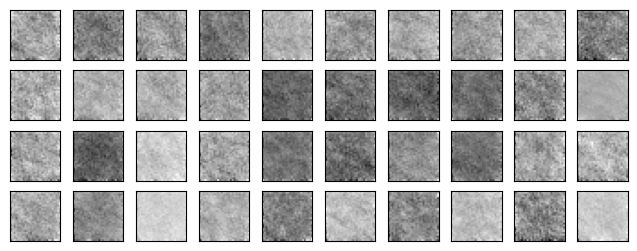

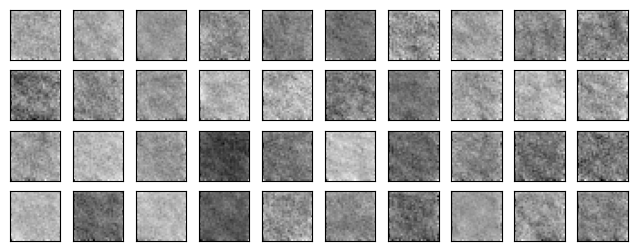

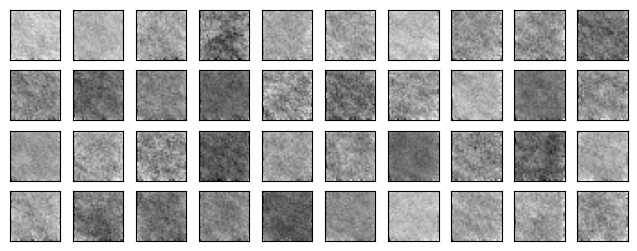

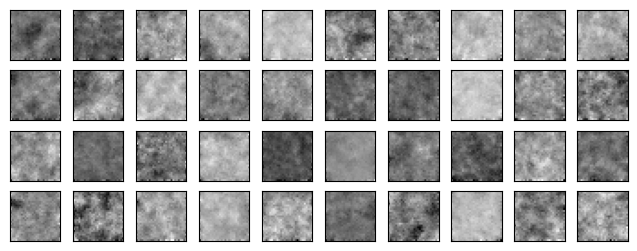

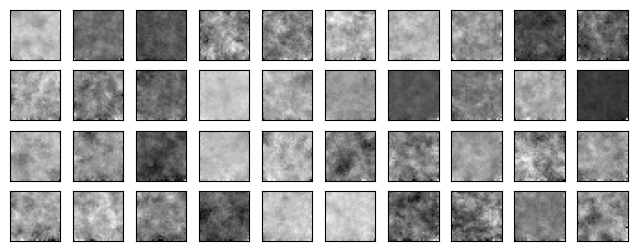

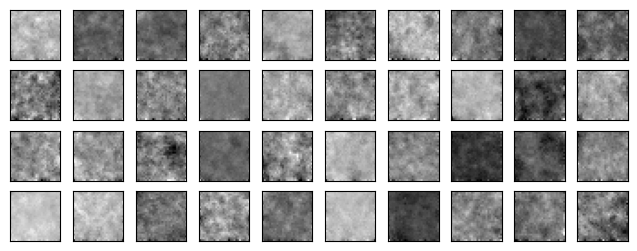

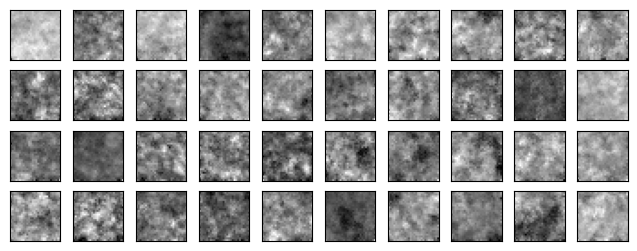

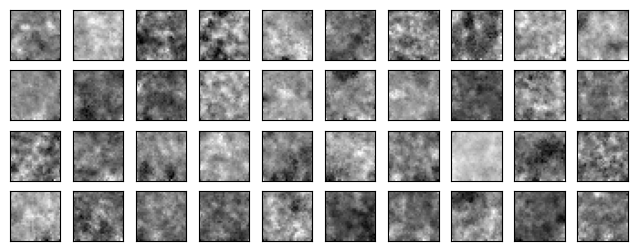

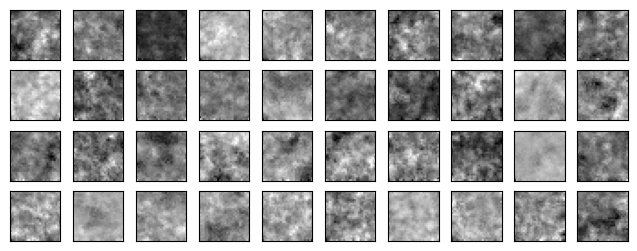

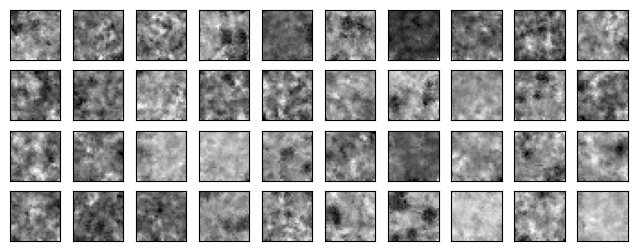

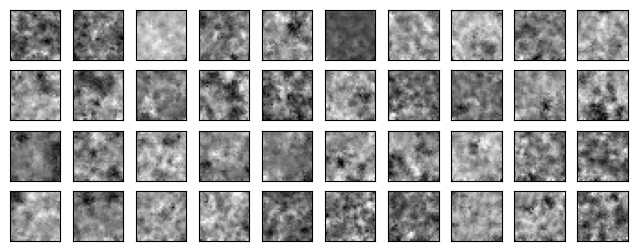

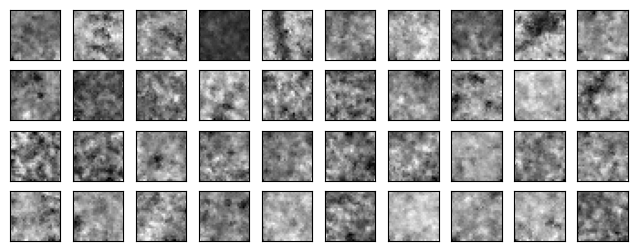

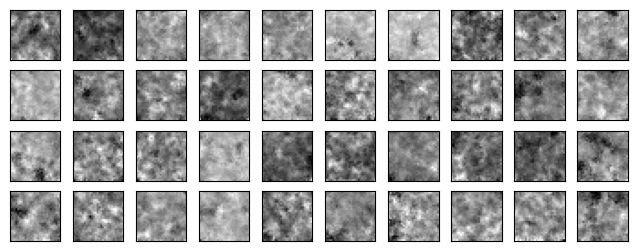

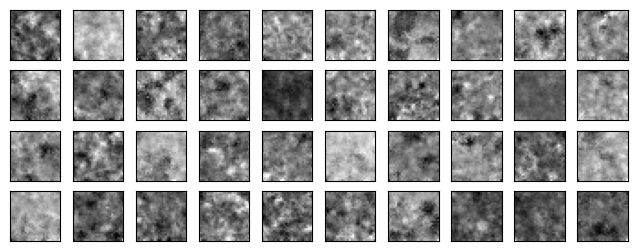

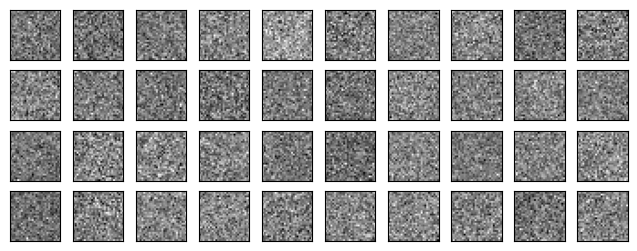

In [45]:
for ep in range(n_epoch):
    print(f"epoch {ep}")
    ddpm.train()

    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None

    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        c = torch.zeros(x.shape[0], dtype=int).to(device)
        loss = ddpm(x, c) # 计算损失函数大小
        loss.backward() # 计算损失函数斜率
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step() # 更新神经网络参数值

    ddpm.eval()
    with torch.no_grad():
        n_sample = 4 * n_classes
        for w_i, w in enumerate(ws_test):
            # print("w_i, w =", w_i, w)
            x_gen, x_gen_store = ddpm.sample(n_sample, (1,28,28), device, guide_w=w)
            # print("x_gen.shape =", x_gen.shape, "x_gen_store.shape =", x_gen_store.shape)
            x_real = torch.Tensor(x_gen.shape).to(device)
            # print("x_real.shape =", x_real.shape)
            for k in range(n_classes):
                for j in range(int(n_sample/n_classes)):
                    try:
                        idx = torch.squeeze((c==k).nonzero())[j]
                    except:
                        idx = 0
                    # print("k+j*n_classes =", k+j*n_classes, "idx =", idx)
                    x_real[k+j*n_classes] = x[idx]

            # print("x_gen.shape =", x_gen.shape, "x_real.shape =", x_real.shape)
            x_all = torch.cat([x_gen, x_real])
            # print("x_all.shape =", x_all.shape)
            grid = make_grid(x_all*-1+1, nrow=10)
            # print("save start")
            save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
            print("save image at", save_dir, f"image_ep{ep}_w{w}.png")

            if ep%5==0 or ep==int(n_epoch-1):
                fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                def animate_diff(i, x_gen_store):
                    print(f"gif animating frame {i} of {x_gen_store.shape[0]}", end="\r")
                    plots = []
                    for row in range(int(n_sample/n_classes)):
                        for col in range(n_classes):
                            # print("row =", row, "col =", col)
                            axs[row, col].clear()
                            axs[row, col].set_xticks([])
                            axs[row, col].set_yticks([])
                            plots.append(axs[row, col].imshow(
                                x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                            # plots.append(axs[row,col].imshow(
                            #     -x_gen_store[i,row*n_classes+col,0],
                            #     cmap='gray', vmin=-x_gen_store[i].min(),
                            #     vmax=-x_gen_store[i].max()
                            # ))
                    return plots
                ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200,blit=False,repeat=True,frames=x_gen_store.shape[0])
                ani.save(save_dir+f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                print("save image at", save_dir, f"gif_ep{ep}_w{w}.gif")

    if save_model and ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir+f"model_{ep}.pth")
        print("save model at", save_dir, f"model_{ep}.pth")

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

# test on 21cm dataset

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import numpy as np
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
import h5py
from datasets import Dataset

@dataclass
class TrainingConfig:
    image_size = [64,512]
    train_batch_size = 16
    eval_batch_size = 24
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 10
    mixed_precision = 'fp16'
    output_dir = "diffusion21cm"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()
# config.dataset_name = "diffusion21cm"
# dataset = load_dataset(config.dataset_name, split='train')

In [ ]:
ls $SCRATCH/

datasets/         max_redshift.ipynb  test.txt  version_diffusers_cache.txt
LEN512-DIM256.h5  test.h5             token


In [ ]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5", 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    Tb = f['brightness_temp'][:10,0,:,:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances', 'xH_box']>
<HDF5 dataset "brightness_temp": shape (600, 256, 256, 514), type "<f4">


(10, 256, 514)
<class 'numpy.ndarray'>


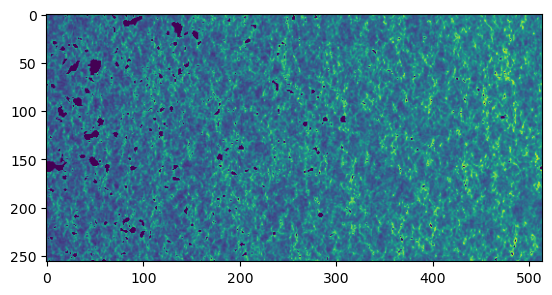

In [ ]:
print(Tb.shape)
print(type(Tb))
# plt.imshow(Tb[0])
plt.imshow(Tb[0])

In [ ]:
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')
# print(dataset.shape)
# print(type(dataset))
# print(dataset)
# print(dataset[0]['image'].convert('RGB'))
# print(np.shape(dataset[0]['image']))
# dataset[0]['image'].convert('RGB')

In [ ]:
def load_numpy_dataset(np_array, split='train'):
    assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
    dataset = Dataset.from_dict({'image': np_array})
    return dataset
dataset = load_numpy_dataset(Tb)
print(type(dataset))
print(len(dataset))
print(np.shape(dataset))
print(dataset)
print(np.shape(dataset[0]['image']))

AttributeError: type object 'Dataset' has no attribute 'from_dict'

(256, 514)
0.0 67.30357360839844


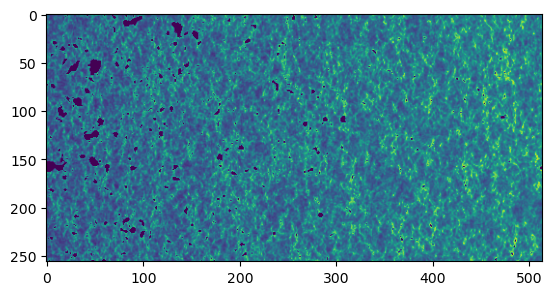

In [ ]:
test = np.array(dataset[0]['image'])
print(test.shape)
print(test.min(), test.max())
test = (test-test.min())/(test.max()-test.min())
# plt.imshow((test*255).astype(np.int))
plt.imshow(test)
plt.show()

In [ ]:
def normalize(image):
    initial_data = np.array(image)
    data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
    # data = (normalized_data*255).astype(np.uint8)
    data = Image.fromarray(np.uint8(data*255))
    return data

preprocess = transforms.Compose(
    [
        # normalize(),
        transforms.Resize((config.image_size[0], config.image_size[1])),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(normalize(image)) for image in examples['image']]
    # images = [preprocess(image) for image in examples['image']]
    # print(np.shape(images[0]))
    return {"images": images}

# datasets = transform(Tb)
dataset.set_transform(transform)

In [ ]:
dataset[0]['images'].shape

torch.Size([1, 64, 512])

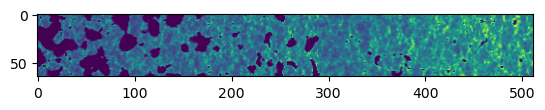

In [ ]:
plt.imshow(dataset[0]['images'][0])

In [ ]:
# dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
next(iter(train_dataloader))['images'].shape

torch.Size([16, 1, 64, 512])

In [ ]:
model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=12, cols=2)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
    
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)


In [ ]:
# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

/scratch/5495298/ipykernel_22069/2220207547.py:3: RuntimeWarning: invalid value encountered in true_divide
  data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712107271.atl1-1-03-004-33-0.pace.gatech.edu.90591.0:   0%|          | 0.00/25.9k [00:00<…

events.out.tfevents.1712107175.atl1-1-03-004-33-0.pace.gatech.edu.1952.0:   0%|          | 0.00/1.45k [00:00<?…

events.out.tfevents.1712109728.atl1-1-03-004-33-0.pace.gatech.edu.252572.0:   0%|          | 0.00/91.9k [00:00…

events.out.tfevents.1712109230.atl1-1-03-004-33-0.pace.gatech.edu.86105.0:   0%|          | 0.00/53.4k [00:00<…

events.out.tfevents.1712109547.atl1-1-03-004-33-0.pace.gatech.edu.199669.0:   0%|          | 0.00/88.0 [00:00<…

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1712110827.atl1-1-03-004-33-0.pace.gatech.edu.11893.0:   0%|          | 0.00/78.1k [00:00<…

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/78.1k [00:00<…

0009.png:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/156k [00:00<?…

0019.png:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

0029.png:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/234k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/312k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/390k [00:00<?…

0049.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0044.png:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 